# Overview

GliNER is a zero-shot named entity recognition (NER) model. This means you can use GliNER to identify a custom set of labels by passing a text and your labels to the model at the same time. Gliner spaCy is a spaCy extension that allows you to bring a GliNER output into a spaCy pipeline.

# Getting Started

In this notebook, we will examine GliNER Cat, a new approach to performing sentence-level text classification with GliNER. To do this, we first need to import spaCy

In [1]:
import spacy

With spaCy imported, we now need to create the structured data that Gliner Cat expects. Our data, looks like this dictionary.

In [2]:
cat_data = {
    "family": ["child", "spouse", "family", "parent"],
    "labor": ["work", "job", "office"],
    "education": ["school", "student"],
    "movement": ["verb of movement", "place of movement"],
    "violence": ["violence", "weapon", "attack", "fear"]
}

This dictionary has a set of keys. These keys are our themes that we want to identify. Each key maps to a set of labels which will be sent to GliNER. Gliner Cat will use the output from these labels to map the results back to their corresponding theme. To get a unique set of labels, we can use the following code snippet.

In [3]:
labels = []
for cat, cat_labels in cat_data.items():
    for label in cat_labels:
        labels.append(label)
labels = list(set(labels))
print(labels)

['attack', 'spouse', 'weapon', 'office', 'student', 'verb of movement', 'violence', 'fear', 'family', 'child', 'place of movement', 'work', 'school', 'job', 'parent']


Now that we have our data, we can design our spaCy pipeline. We will be using a blank English model. Gliner Cat requires a sentencizer, though, so we will add one to the pipeline. It also requires a Gliner spaCy component, so we will add that as well. I find using a `span` style improves the results because it allows GliNER to annotate tokens with multiple labels. We will also set our threshold for GliNER to `.5`, which will keep the false positives lower. Finally, we add our Gliner Cat component. We specify a `chunk_size` of `100`. This will visualize our data in 100-sentence chunks.

In [4]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")
nlp.add_pipe("gliner_spacy", config={"labels": labels, "style": "span","threshold": .50})
nlp.add_pipe("gliner_cat", config={"cat_data": cat_data, "style": "span"})

/Applications/anaconda3/envs/gliner-spacy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Applications/anaconda3/envs/gliner-spacy/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Now, we will load up a oral testimony from the USHMM.

In [5]:
with open("data/testimony.txt", "r", encoding="utf-8") as f:
    text = f.read()

Finally, we can process our text.

In [6]:
doc = nlp(text)

Once complete, we can access the theme data for each sentence.

In [7]:
sents = list(doc.sents)
print(sents[200].text)
sents[200]._.raw_scores

Q: You worked with your father?


{'family': [0.9034066796302795],
 'labor': [],
 'education': [],
 'movement': [],
 'violence': []}

As we can see this sentence deals with family. Let's find out why, though.

In [8]:
for ent in sents[200]._.sent_spans:
    print(ent.text, ent.label_, ent._.score)

father parent 0.9034066796302795


Here, we can see the word `father` is the reason why we have a theme of family being discussed. We see that `father` aligns with the NER label of `parent`, as one would expect.

Now that we have processed our text, we can visualize it with the `visualize()` method.

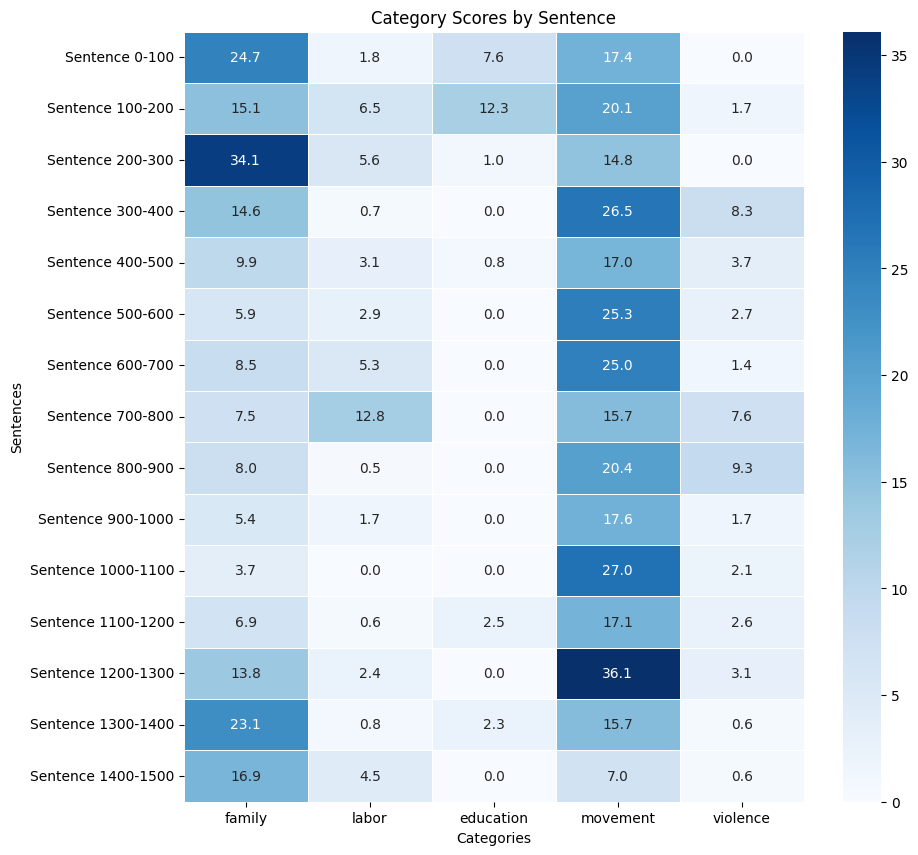

In [9]:
doc._.visualize(sent_start=0, sent_end=None, chunk_size=100, fig_h=10)

From this chart, we can easily see that family features heavily in the beginning and end of this testimony. Movement appears throughout, while education is almost exclusively featured in the earlier parts. Labor appears only in the first half with a spike half-way through the testimony. Likewise, violence spikes around this same time.

Let's examine why section 200-300 features family so strongly.

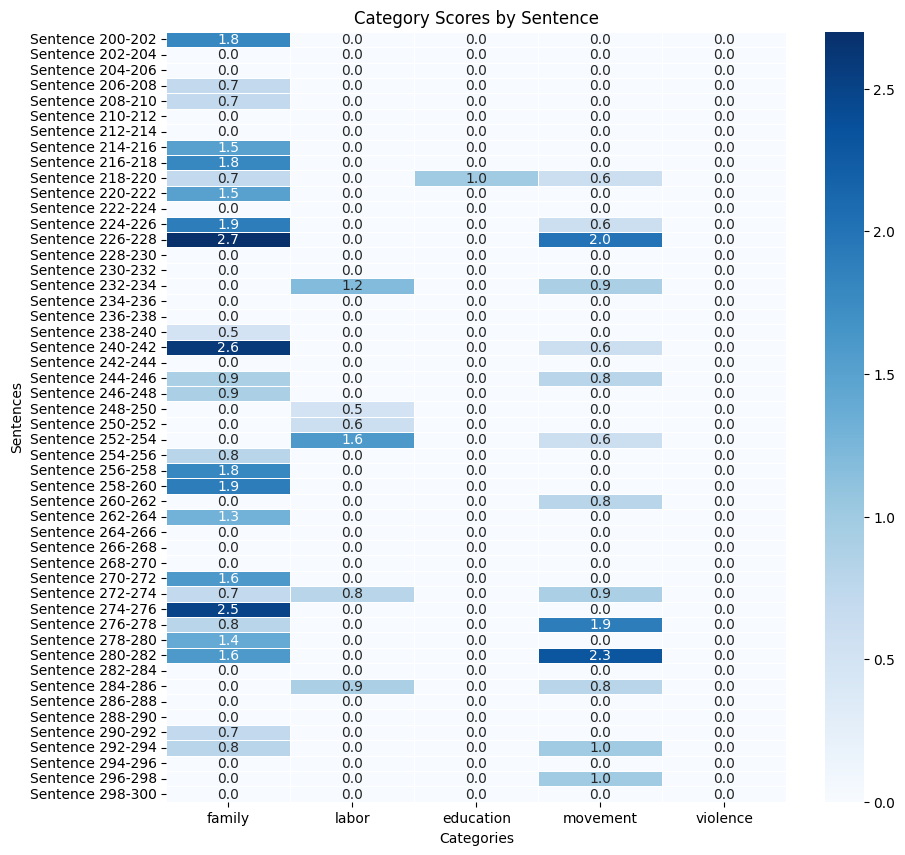

In [10]:
doc._.visualize(sent_start=200, sent_end=300, chunk_size=2, fig_h=10)

In [12]:
from spacy import displacy

In [13]:
sent_text = "\n".join([sent.text for sent in sents[226:228]])
sent_doc = nlp(sent_text)

In [14]:
displacy.render(sent_doc, style="span", options={"spans_key": "sc"})

As we can see, this section speaks heavily about the speaker's family and their childhood. The speaker describes their father, little sister, etc.

# Conclusion

While this approach to text classification is not perfect, it offers a way to use a structured schema so that we know specifically what features of a sentence lead to a specific classification. Further, since this approach is rooted in zero-shot NER, it allows it be easily adjusted and facilitates rapid experimentation.